<img src="https://i.pngimg.me/thumb/f/720/comvecteezy492057.jpg" style="float: left; margin: 20px; height: 85px">

# Classification Project
## Relationship Status Group Prediction

--- 
# Part 3 - Modelling

---

In [1]:
import sys  
sys.path.insert(1, '../../project-3')
from Class_Train import To_Train

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import FunctionTransformer

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
date_marry = pd.read_csv('../output/marriage_dating.csv')
date_marry.head()

,Unnamed: 0,title,self_text,subreddit
0,0,What does it mean when a girl says I don’t fee...,I had a date yesterday and I thought it was ok...,dating
1,1,why do some guys get hurt/bothered if you slee...,My ex recently found out I hooked up with some...,dating
2,2,Worst era to ever date in as a guy.,Is there a single (attractive) young woman (ea...,dating
3,3,"Why do some men hate ""Vanilla women""?","Hiya. Earlier today I got called a ""vanilla wo...",dating
4,4,Guys the Victim mentality WONT help you,I've been couple of years in this sub and that...,dating


In [3]:
to_train = To_Train()
date_marry = to_train(date_marry)
date_marry.drop('Unnamed: 0', axis=1, inplace=True)
date_marry.head()

,subreddit,all_text,text_length,special_characters,compounds,neg,pos
0,1,What does it mean when a girl says I don’t fee...,693,168,0.9412,0.016,0.140
1,1,why do some guys get hurt/bothered if you slee...,336,70,-0.4004,0.127,0.104
2,1,Worst era to ever date in as a guy. Is there a...,269,64,-0.2732,0.076,0.074
3,1,"Why do some men hate ""Vanilla women""? Hiya. Ea...",679,151,0.9606,0.043,0.198
4,1,Guys the Victim mentality WONT help you I've b...,1071,246,-0.9569,0.186,0.093


# Modelling

<span style="font-size: 16px;"> First, let's pick between using the numerical columns created in the class To_Train or using only the text of the posts. <br>
Then, TfidfVectorizer and CountVectorizer will be compared.<br>
After choosing the vectorizer for the texts, different models will be tested to choose the best one<Br>
At last, the coefficients for the linear models will be evaluated to see if they can give us an idea of the main issues of each group.<br>

## Choosing to use numericals columns or not

<span style="font-size: 16px;">
    With text and numericals columns created from texts:

In [5]:
X = date_marry.drop('subreddit', axis=1)
y = date_marry['subreddit']

In [6]:
numerical_cols = list(date_marry.select_dtypes(include='number'))
numerical_cols.remove('subreddit')

num_transformer = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(max_df=0.95, min_df=5), 'all_text'),
        ('sc', StandardScaler(), numerical_cols)
    ])

# Create the pipelines
num_pipe = Pipeline([
    ('preprocessing', num_transformer),
    ('model', RidgeClassifier())
    ])

print(f"Cross Validation accuracy score using all columns with RidgeClassifier:")
print(np.mean(cross_val_score(num_pipe, X, y, cv=5, scoring='accuracy')))

Cross Validation accuracy score using all columns with RidgeClassifier:
0.8099817446582627


<span style="font-size: 16px;"> Now, using only the vectorized text:

In [8]:
X = date_marry['all_text']
y = date_marry['subreddit']

text_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', RidgeClassifier())
    ])

print(f"Cross Validation accuracy score using only text with RidgeClassifier:")
print(np.mean(cross_val_score(text_pipe, X, y, cv=5, scoring='accuracy')))

Cross Validation accuracy score using only text with RidgeClassifier:
0.8376923176515776


<span style="font-size: 16px;"> Using the features created from the texts led to a worse score than using just text... Let's only use the text from now on to define the vectorizer, choose the most adequate model and to see the most important features for each class.

> <span style="font-size: 17px;"> Only text will be used!

In [9]:
date_marry = date_marry[['subreddit', 'all_text']]

# Choosing the vectorizer

<span style="font-size: 16px;">Applying CountVectorizer on the text led to a 83% accuracy score using the default parameters. Let's now see how TfidfVectorizer goes...

In [11]:
tfidf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RidgeClassifier())
    ])

print(np.mean(cross_val_score(tfidf_pipe, X, y, cv=5, scoring='accuracy')))

print(f"Cross Validation accuracy score using TfidfVectorizer with RidgeClassifier:")
print({np.mean(cross_val_score(tfidf_pipe, X, y, cv=5, scoring='accuracy'))})

0.9511770307808941
Cross Validation accuracy score using TfidfVectorizer with RidgeClassifier:
{0.9511770307808941}


<span style="font-size: 16px;">TfidfVectorizer had a boost of more than 11% in accuracy score! I will use this vectorizer from now on. <br> <Br>
    As seen in EDA notebook, the groups have the same 6 out of the 10 most common words. </span> <br><span style="font-size: 16px;">*"In a large text corpus, some words appear with higher frequency (e.g. “the”, “a”, “is” in English) and do not carry meaningful information about the actual contents of a document. If we were to feed the word count data directly to a classifier, those very common terms would shadow the frequencies of rarer yet more informative terms."* ([text from this scikit example](https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html#sphx-glr-auto-examples-text-plot-hashing-vs-dict-vectorizer-py)) <br><br> </span>
    <span style="font-size: 16px;">TfidfVectorizer takes this into account and carries an inverse transform on the count frequencies of words. This led to a much better score using RidgeClassifier.

> <span style="font-size: 17px;">TfidfVectorizer it is!

## Choosing models and parameters

 <span style="font-size: 16px;">Since the main interest is accuracy overall, not giving a class a bigger importance, accuracy will be the score to choose the models and parameters.

In [12]:
X = date_marry['all_text']
y = date_marry['subreddit']

### - Ridge Classifier:

In [13]:
ridge_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RidgeClassifier())
    ])

In [14]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()), ('model', RidgeClassifier())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'model': RidgeClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'model__alpha': 1.0,
 'model__class_weight': None,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model_

In [15]:
ridge_params = {
    'vectorizer__ngram_range': [(1, 1), (1,2), (2,2)],
    'vectorizer__stop_words': [None, 'english'],
    'vectorizer__max_df': [0.9, 1.0],
    'vectorizer__min_df': [5, 7],
    'model__alpha': [1.0, 0.8]
}

In [16]:
ridge_grid = GridSearchCV(ridge_pipe,
                     param_grid = ridge_params,
                     cv = 5, scoring='accuracy')

In [17]:
ridge_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('model', RidgeClassifier())]),
             param_grid={'model__alpha': [1.0, 0.8],
                         'vectorizer__max_df': [0.9, 1.0],
                         'vectorizer__min_df': [5, 7],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': [None, 'english']},
             scoring='accuracy')

In [18]:
ridge_grid.best_params_

{'model__alpha': 1.0,
 'vectorizer__max_df': 1.0,
 'vectorizer__min_df': 7,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': None}

In [19]:
print('GridSearchCV Accuracy Score with RidgeClassifier:')
print(ridge_grid.score(X, y))

GridSearchCV Accuracy Score with RidgeClassifier:
0.9968809980806143


 <span style="font-size: 16px;">Really high score... Let's see if other classifiers also reach 99.7% of accuracy...

### - Logistic Regression

In [20]:
logreg_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=1.0, min_df=7, ngram_range=(1,2), stop_words=None)),
    ('logreg', LogisticRegression())
    ])

In [21]:
print(f"Cross Validation Score for Logistic Regression:")
print(np.mean(cross_val_score(logreg_pipe, X, y, cv=5, scoring='accuracy')))

Cross Validation Score for Logistic Regression:
0.9464988297304568


### - Random Forest

In [22]:
random_forest_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=1.0, min_df=7, ngram_range=(1,2), stop_words=None)),
    ('random_forest', RandomForestClassifier())
    ])

In [23]:
random_forest_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer(min_df=7, ngram_range=(1, 2))),
  ('random_forest', RandomForestClassifier())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(min_df=7, ngram_range=(1, 2)),
 'random_forest': RandomForestClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 7,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'random_forest__bootstrap'

In [24]:
print(f"Cross Validation Score for Random Forest:")
print(np.mean(cross_val_score(random_forest_pipe, X, y, cv=5, scoring='accuracy')))

Cross Validation Score for Random Forest:
0.940980293150003


### - KNeighbors

In [25]:
kneighbors_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=1.0, min_df=7, ngram_range=(1,2), stop_words=None)),
    ('kneighbors_clf', KNeighborsClassifier())
    ])

In [26]:
kneighbors_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer(min_df=7, ngram_range=(1, 2))),
  ('kneighbors_clf', KNeighborsClassifier())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(min_df=7, ngram_range=(1, 2)),
 'kneighbors_clf': KNeighborsClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 7,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'kneighbors_clf__algorithm':

In [27]:
kneighbors_params = {'kneighbors_clf__n_neighbors': [5, 8, 10, 15, 20]}

In [28]:
kneighbors_grid = GridSearchCV(kneighbors_pipe,
                     param_grid = kneighbors_params,
                     cv = 5, scoring='accuracy')

In [29]:
kneighbors_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=7,
                                                        ngram_range=(1, 2))),
                                       ('kneighbors_clf',
                                        KNeighborsClassifier())]),
             param_grid={'kneighbors_clf__n_neighbors': [5, 8, 10, 15, 20]},
             scoring='accuracy')

In [30]:
kneighbors_grid.score(X, y)

0.7936660268714012

In [33]:
X.shape

(8336,)

<span style="font-size: 17px;">Let's calculate the sparsity of the vectorized matrix - code inspired by [this scikit example](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [38]:
# Vectorizing X['all_text']
X = date_marry['all_text']
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

print('Sparse matrix of texts using TfidfVectorizer:')
# non zero entries divided by total number of entries:
print(X_tfidf.nnz/np.prod(X_tfidf.shape))

Sparse matrix of texts using TfidfVectorizer:
0.0048614877492942675


<span style="font-size: 16px;"> KNeighbors Classifier had the worst score between the 4 models... This is due to the curse of dimensionality, X is a sparse matrix with 8336 dimensions, which makes it difficult to find neighbors around data points.

> <span style="font-size: 17px;"> RidgeClassifier it is!

# Confusion Matrix of Best Model

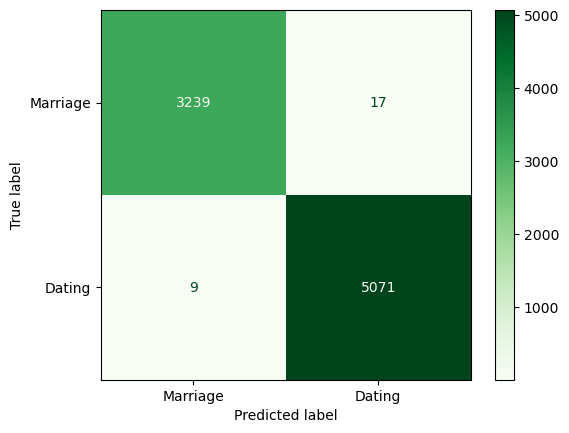

In [31]:
ConfusionMatrixDisplay.from_estimator(ridge_grid, X, y, cmap='Greens')
plt.xticks([0, 1], ['Marriage', 'Dating'])
plt.yticks([0, 1], ['Marriage', 'Dating']);

<span style="font-size: 16px;"> RidgeClassifier got more marriage subreddit texts wrong than the other way around, probably of an unbalanced data. Data had around 60% of dating subreddit posts and 40% of marriage subreddit posts. Besides that, the result does not seem to have a pattern of confusion between classes. Afterall, the accuracy score was more than 99%.

# Conclusions

<span style="font-size: 16px;">Ridge Classifier had a better accuracy score, so it is the most adequate for this project. The penalized linear classifier was more than 11% better in accuracy than Logistic Regression with no penalization.<br>
The score reached was really high, so it leads us to think the model is great in predicting from texts from which group the person belongs.    
<Br>Using the best linear model (which had the best accuracy score overall), I will see the importance of words for each group seeing which words had the highest coefficients. <Br>
<br> Code below inspired by [this scikit example](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py)

In [43]:
X = date_marry['all_text']
tfidf = TfidfVectorizer(max_df=1.0, min_df=7, ngram_range=(1,2), stop_words=None)
X_tfidf = tfidf.fit_transform(X)

In [45]:
final_model = RidgeClassifier(alpha= 1.0)
final_model.fit(X_tfidf, date_marry['subreddit'])

RidgeClassifier()

In [47]:
target_names = ['marriage', 'dating']

final_model.coef_

array([[ 0.05294163, -0.18876501, -0.29625198, ...,  0.02959193,
         0.17966473,  0.07899638]])

<span style="font-size: 16px;">In the case of binary classification, the .coef_ attribute of the RidgeClassifier has shape (1, n_features). This way, I will sort the coefficients and get the smallest 5 and greatest 5. These will be the most correlated to marriage posts and dating posts, respectively.

In [51]:
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '000', '10', ..., 'zone and', 'zoned', 'zoo'], dtype=object)

In [78]:
# learned coefficients weighted by frequency of appearance
average_feature_effects = final_model.coef_ * np.asarray(X_tfidf.mean(axis=0)).ravel()
sorted_indices = np.argsort(average_feature_effects[0])[::-1]
top20_dating = sorted_indices[:20]
top20_marriage = sorted_indices[-20:]

print('top 20 words for dating:')
print(feature_names[top20_dating])
print()
print('top 20 words for marriage:')
print(feature_names[top20_marriage])

top 20 words for dating:
['dating' 'me' 'date' 'guy' 'relationship' 'someone' 'women' 'girl' 'like'
 'but' 'in' 'out' 'people' 'men' 'for' 'on' 'guys' 'want' 'talking'
 'first']

top 20 words for marriage:
['we' 'have' 'him' 'spouse' 'her' 'years' 'this' 'she' 'my' 'our'
 'my wife' 'to' 'my husband' 'married' 'marriage' 'it' 'wife' 'the' 'he'
 'husband']
